# Waterbody Time Series with Sentinel 2

In [1]:
#%%bash
#pip install ephem
#pip install --index-url https://packages.dea.ga.gov.au/ wofs

In [2]:
import csv
from pathlib import Path
import warnings

import datacube
import geopandas as gpd
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
import rasterio
import rioxarray
import scipy.optimize as opt

import sys
sys.path.insert(1, "../Tools/")
from dea_tools import waterbodies
from dea_tools.spatial import xr_rasterize
from dea_tools.datahandling import load_ard
from dea_tools.plotting import rgb, plot_wo, display_map
from dea_tools import S2_wofls

#import wofs.wofls
#from wofs import classifier, filters
import rioxarray

#from dea_tools.S2_wofls import woffles_ard


In [3]:
# Set up the datacube:
dc = datacube.Datacube(app="WaterbodyTimeSeriesS2")

In [4]:
geohash = "r1uqwu1tj_v3" # Lake Victoria
#ts_sa = get_time_series(geohash=geohash)

In [6]:
# Load the waterbody shape:
shape = waterbodies.get_waterbody(geohash)

time_period = ("2015-08-01", "2017-01-01")

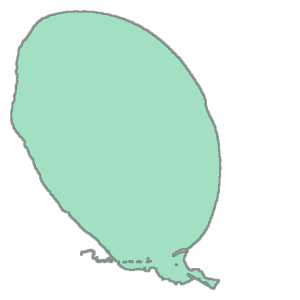

In [7]:
shape.geometry[0]

In [ ]:
ds = load_ard(
    dc,
    products=["ga_s2am_ard_3", "ga_s2bm_ard_3"],
    resolution=(-10, 10),
    output_crs="EPSG:3577",
    min_gooddata=0.9,
    geopolygon=datacube.utils.geometry.Geometry(
        shape.geometry[0].buffer(100), crs="EPSG:3577"
    ),
    time=time_period,
)

Finding datasets
    ga_s2am_ard_3
    ga_s2bm_ard_3
Counting good quality pixels for each time step using fmask
Filtering to 31 out of 82 time steps with at least 90.0% good quality pixels
Applying fmask pixel quality/cloud mask
Loading 31 time steps


In [ ]:
rgb(ds.isel(time=-1))

## Run WOfS

In [ ]:
#from dea_tools.S2_wofls import MASKED_CLOUD, MASKED_CLOUD_SHADOW, NO_DATA

In [ ]:
# Open the DEM, which is in EPSG:3577
dem = rioxarray.open_rasterio("lakevictoria.tif")

# define nodata values https://corteva.github.io/rioxarray/stable/getting_started/nodata_management.html
nodata = dem.rio.nodata

In [ ]:
# Screen out no-data
dem = dem.where(dem != nodata)
#print(dem)
print(nodata)

In [ ]:
# Set zero pixels (water) to the minimum to avoid edge effects in WOfS terrain shadows
dem.isel(band=0).values[(dem == 0).values[0]] = dem.where(dem > 0).min()

In [ ]:
# Convert into an xarray dataset for WOfS
dem = xr.Dataset({"elevation": dem.isel(band=0)})

In [ ]:
# Set nodata attrs
ds.attrs["nodata"] = np.nan
for band in ds.variables:
    ds[band].attrs["nodata"] = np.nan

In [ ]:
# and the CRS
dem.attrs["crs"] = "EPSG:3577"

In [ ]:
# reproject the DEM
transform, width, height = rasterio.warp.calculate_default_transform(
    "EPSG:3577", "EPSG:3577", dem.rio.width, dem.rio.height, *dem.rio.bounds()
)

In [ ]:
dem_reproj = rasterio.warp.reproject(
    source=dem.elevation,
    src_transform=dem.rio.transform(),
    src_crs=dem.crs,
    destination=ds.rename({"nbart_blue": "elevation"}).elevation.isel(time=0).copy(),
    dst_transform=ds.rio.transform(),
    dst_crs=ds.crs,
    resampling=rasterio.warp.Resampling.bilinear,
)[0]

In [ ]:
# create the cloud mask
#fmask = ds.oa_fmask
#print(fmask)
#shape = fmask.shape
#print(shape)

In [ ]:
#test = ds.isel(time=0)
#ard = test

#fmask = test.oa_fmask
#print(fmask)
#shape = fmask.shape
#print(shape)

In [ ]:
s2_wofls = []
for i in tqdm(range(len(ds.time))):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        s2_wofls_ = woffles_ard(
            ds.rename(
                {
                    "nbart_nir_1": "nbart_nir",
                    "nbart_swir_2": "nbart_swir_1",
                    "nbart_swir_3": "nbart_swir_2",
                }
            ).isel(time=i),
            xr.Dataset({"elevation": dem_reproj}, attrs={"crs": "EPSG:3577"}),
        )
        s2_wofls.append(s2_wofls_)

In [ ]:
s2_wofs = xr.concat(s2_wofls, dim="time")

In [ ]:
fmask = (ds["oa_fmask"] == 1) | (ds["oa_fmask"] == 5) | (ds["oa_fmask"] == 4)

In [ ]:
print(fmask)

In [ ]:
s2_wofs = s2_wofs.where(((s2_wofs == 128) | (s2_wofs == 0)) & fmask)

In [ ]:
s2_wofs = (s2_wofs == 128).where(~s2_wofs.isnull())

In [ ]:
s2_wofs.isel(time=range(0, 30, 3)).astype(float).plot(
    col="time", col_wrap=4, add_colorbar=False
)

## Extract the time series

Next we apply the waterbody as a mask.

Yellow = pixel identified as wet

In [ ]:
# Convert the shape into a raster mask:
mask = xr_rasterize(shape, s2_wofs)

In [ ]:
# Apply the mask:
s2_wofs_masked = s2_wofs.where(mask)

In [ ]:
# Visualise the results
s2_wofs_masked.isel(time=range(0, 30, 3)).astype(float).plot(
    col="time", col_wrap=4, add_colorbar=False
)

The time series is then just the sum of valid pixels.

In [ ]:
ts_sa_s2 = s2_wofs_masked.sum(dim=["x", "y"])

Apply a filter that excludes scenes with less than 90% valid pixels. Count how many pixels are missing compared to how many pixels are in the mask:

In [ ]:
masked_pixel_counts = s2_wofs_masked.isnull().sum(dim=["x", "y"])
n_masked_pixels = (1 - mask).sum()
missing_pixel_counts = masked_pixel_counts - n_masked_pixels

In [ ]:
print(masked_pixel_counts)

In [ ]:
print(missing_pixel_counts)

In [ ]:
# Convert to a percentage of the maximum extent
missing_pixel_pcs = missing_pixel_counts / mask.sum()

In [ ]:
print(missing_pixel_pcs)

In [ ]:
# Apply the filter
ts_sa_s2 = ts_sa_s2.sel(time=missing_pixel_pcs <= 0.1)

In [ ]:
print(ts_sa_s2)

We can also estimate the upper bound as the measured value plus the number of missing pixels.

In [ ]:
upper_bound = ts_sa_s2 + missing_pixel_counts

One frame seems to be missing all pixels, so we will exclude it.

In [ ]:
upper_bound = upper_bound.sel(time=ts_sa_s2 > 0)
ts_sa_s2 = ts_sa_s2.sel(time=ts_sa_s2 > 0)

In [ ]:
plt.figure(figsize=(15, 4))
plt.fill_between(ts_sa_s2.time.values, ts_sa_s2, upper_bound, alpha=0.5 )
ts_sa_s2.plot()
plt.title("Lake Victoria Surface Area — Sentinel 2")
plt.xlabel("Date")
plt.ylabel("Surface area (px$^2$)")

# Format y-axis tick labels to 3 significant figures
plt.gca().yaxis.set_major_formatter(plt.FormatStrFormatter('%.12g'))

# Show the plot
plt.show()

## Compare to Landsat time series 

In [ ]:
plt.figure(figsize=(15, 4))
get_time_series(geohash="r1uqwu1tj_v3")["px_wet"].iloc[458:482].plot()
plt.ylabel("Number of wet pixels");

In [ ]:
df = ts_sa_s2.to_dataframe(name="px_wet")
df.index = df.index.tz_localize("UTC")
ts_sa_s2 = df

In [ ]:
plt.figure(figsize=(15, 4))
get_time_series(geohash="r1uqwu1tj_v3")["px_wet"].iloc[458:482].plot(label="landsat", c='orange')
ts_sa_s2.px_wet.plot(
    label="wet px count — sentinel 2", c="firebrick"
)
#plt.xlim(ts_sa_s2.index[0], ts_vol.index[-1])
plt.ylabel("Surface area (px$^2$)")
plt.xlabel("Date")
plt.legend();